
# Trabalho 3

## Grupo 24

### Pedro Faria - A72640
### Hugo Costeira - A87976

# $a$

Como é dado no enunciado existe 5 modos, nomeadamente: $START\,FREE\,STOPPING\,BLOCKED\,STOPPED$


Enquanto a velocidade do carro for diferente de 0 ($v_{stopped}$), o carro irá estar num loop entre FREE, STOPPING e BLOCKED. 

A mudança de modo FREE e STOPPING é determinada pelos invariantes: tm < 0.3 e V-v< 0.5 ($tmax\_free$ e $d\_free$). 

O carro ficará com as rodas bloqueadas quando a diferença de velocidades for menor que $1\,m/s$ ($d\_stop$)

Case as rodas estejam bloqueadas mais que $0.2s$ ($tmax\_blocked$) o ABS deixará de travar (passando do modo $BLOCKED$ para o modo $FREE$)

O estado inicial do FOTS é derivado facilmente a partir da definição do autómato híbrido. Por exemplo, no caso do ABS temos:
$$ m = START\,\land\, t = 0 \,\land\,tm=0\,\land\, v=v_0 \,\land\, V = v_0$$

As transições do FOTS incluem os dois tipos de transição que podem ocorrer num autómato híbrido:
- Transições *timed* descrevem os *flows* associados a cada modo (a evolução das variáveis contínuas)
- Transições *untimed* descrevem os *switches* entre modos

As transições *untimed* podem ser obtidas através de uma codificação muito directa das guardas e efeitos especificadas nos *switches*, com a restrição que o tempo não evolui nestas transições, nem as variáveis contínuas se modificam a não ser que lhes seja explicitamente atribuído um novo valor no efeito do *switch*. Por exemplo, no caso do ABS temos 5 transições deste tipo:

$$
m=START\,\land\,m'=FREE\,\land\,t'=t\,\land\,tm'=tm\,\land\,v'=v\,\land\,V'=V 
\\ \lor \\ 
m=FREE\,\land\,m'=STOPPING\,\land\,(tm\ge\,tmax_{free}\,\lor\,V-v\ge\,d_{free})\,\land\,tm'=0 \,\land\,t=t'\,\land\,v=v'\,\land\,V=V'\,\land\,v>v_{stopped}
\\ \lor\\
m=STOPPING \,\land\, m'=BLOCKED \,\land\, t=t' \,\land\,tm=tm'\,\land\,v=v'\,\land\,V=V'\,\land\,V=v <d_{stop} \,\land\, v>v_{stopped}
\\ \lor \\
m=BLOCKED \,\land\, m'=Free \,\land\,tm\ge tmax_{blocked} \,\land\, tm =0 \,\land\, t=t'\,\land\,v=v'\,\land\,V=V'\,\land\,v>v_{stopped}
\\ lor \\ 
(m=BLOCKED\,\lor\,m=STOPPING\,\lor\,m=STOPPED\,\lor\,m=FREE)\,\land\,m'=STOPPED \,\land\,tm=tm'\,\land\,t=t'\,\land\,v\leq v_{stopped} \,\land\,v=0\,\land\,V=0
$$


Nas transições *timed* o modo permanece constante, mas o resto das variáveis evoluem de acordo com as restrições indicadas. Os *flows* são especificados indicando qual a derivada em relação ao tempo de cada variável contínua. Para codificar os *flows* no FOTS é necessário fazer a sua *discretização*, ou seja, indicar qual a variação ocorrida num intervalo de tempo $t'-t$.

$$
m=FREE \,\land\, m'=FREE \,\land\, tm<tmax_{free} \,\land\, V-v <d_{free} \,\land\, t'=t+dt \,\land\,tm' = tm+dt \,\land\,v'= v+(-a*P+c_{free}*(V-v))*dt \,\land\, V'=V+(-c_{free}(V-v)-b)*dt \,\land\,v>v_{stopped}
\\ \lor\\
m=STOPPING\,\land\,m'=STOPPING\,\land\,V-v\ge tmax_{blocked}\,\land\,tm=tm'\,\land\,t'=t+dt\,\land\,v'=v+(-a*P+c_{stopping}*(V-v))*dt\,\land\,V'=V+(-c_{stopping}*(V-v)-b)*dt\,\land\,v>v_{stopped}
\\\lor\\
m=BLOCKED\,\land\,m'=BLOCKED\,\land\,tm<tmax_{blocked}\,\land\,tm+dt=tm'\,\land\,t+dt=t'\,\land\,V'=V+(-a*P-b)*dt\,\land\,v'=V'\,\land\,v>v_{stopped}
$$

# $c$

In [ ]:
!pip install z3-solver
!pip install matplotlib

In [3]:
from z3 import *
import matplotlib.pyplot as plt
Mode, (START,FREE,STOPPING,BLOCKED,STOPPED) = z3.EnumSort ('Mode',('START','FREE','STOPPING','BLOCKED','STOPPED'))

In [4]:


def declare(i):
  s = {}
  s['t']  = Real('t'+str(i))
  s['tm'] = Real('tm'+str(i)) #timer
  s['m']  = Const('m'+str(i),Mode)
  s['v']  = Real('v'+str(i))
  s['V']  = Real('V'+str(i))
  return s

def init(s,v):
  return And(s['t']==0,s['tm']==0,s['m']==START,s['v']==v,s['V']==v)

In [5]:
def trans(s,p):
  #s= estado atual
  #p= posição
  
  dt=0.1
  a=0.01 #constante atrito ar
  b=0.7 # atrito corpo
  P=1000 #peso
  
   #tempo maximo em que está no modo free
  tmax_free=0.3
  #tempo maximo em que está no modo blocked
  tmax_blocked=0.2
  #diferença velocidade free free_stopping
  d_free=0.5
  #diferença velocidade stopping_blocked stopping
  d_stop=1
  #velocidade em que o carro é considerado parado
  v_stopped=0
  #constante porporcionalidade para modo free
  c_free=0.5
  #constante proporcionalidad para stopping
  c_stopping=5
  

  # Untimed
  #Start -> Free
  start_free= And(s['m']==START,
                  p['m']==FREE,
                  p['t']==s['t'],
                  p['tm']==s['tm'],
                  p['v']==s['v'],
                  p['V']==s['V']
                 )

  #Free -> Stopping
  free_stopping= And(s['m']==FREE,
                     p['m']==STOPPING,
                     Or(s['tm']>=tmax_free,s['V']-s['v']>=d_free),
                     p['tm']==0,
                     s['t']==p['t'],
                     s['v']==p['v'],
                     s['V']==p['V'],
                     s['v']>v_stopped
                    )
  #Stopping -> Blocked
  stopping_blocked= And(s['m']==STOPPING,
                        p['m']==BLOCKED,
                        s['t']==p['t'],
                        s['tm']==p['tm'],
                        s['v']==p['v'],
                        s['V']==p['V'],
                        s['V']-s['v']<d_stop,
                        s['v']>v_stopped
                    )
  
  #Blocked -> Free
  blocked_free= And(s['m']==BLOCKED,
                    p['m']==FREE,
                    s['tm']>=tmax_blocked,
                    p['tm']==0,
                    s['t']==p['t'],
                    s['v']==p['v'],
                    s['V']==p['V'],
                    s['v']>v_stopped
                   )
  #Verifica se esta parado
  checkStop= And(Or(s['m']==BLOCKED,s['m']==STOPPING,s['m']==FREE,s['m']==STOPPED),
                 p['m']==STOPPED,
                 s['tm']==p['tm'],
                 s['t']==p['t'],
                 s['v']<=v_stopped,
                 p['v']==0,p['V']==0)
  
  
  

  # Timed
  free= And(s['m']==FREE,p['m']==FREE,s['tm']<tmax_free,s['V']-s['v']<d_free,
                p['t']==s['t']+dt,p['tm']==s['tm']+dt,
                p['v']==s['v']+(-a*P+c_free*(s['V']-s['v']))*dt,p['V']==s['V']+(-c_free*(s['V']-s['v'])-b)*dt,
                s['v']>v_stopped
                )
  
  stopping= And(s['m']==STOPPING,p['m']==STOPPING,
                        s['V']-s['v']>=d_stop,
                        s['tm']==p['tm'],p['t']==s['t']+dt,
                        p['v']==s['v']+(-a*P+c_stopping*(s['V']-s['v']))*dt,p['V']==s['V']+(-c_stopping*(s['V']-s['v'])-b)*dt,
                        s['v']>v_stopped
                        )
  
  blocked= And( s['m']==BLOCKED,p['m']==BLOCKED,
                       s['tm']<tmax_blocked,
                       s['tm']+dt==p['tm'],s['t']+dt==p['t'],
                       p['V']==s['V']+(-a*P-b)*dt,p['v']==p['V'],
                       s['v']>v_stopped
                      )
  return Or(start_free,free_stopping,stopping_blocked,blocked_free,checkStop,free,stopping,blocked)

In [7]:
def gera_traco(declare,init,trans,k,v):
    rodas=[]
    time=[]
    carro=[]
    s = Solver()
    traco = [declare(i) for i in range(k)]
    s.add(init(traco[0],v))
    for i in range(k-1):
      s.add(trans(traco[i],traco[i+1]))

    if s.check()==sat :
       m = s.model()
       for i in range(k):
         print("Estado: ",i)

         rodas.append(float(m[traco[i]['v']].numerator_as_long())/float(m[traco[i]['v']].denominator_as_long()))
         carro.append(float(m[traco[i]['V']].numerator_as_long())/float(m[traco[i]['V']].denominator_as_long()))
         time.append(float(m[traco[i]['t']].numerator_as_long())/float(m[traco[i]['t']].denominator_as_long()))


         for v in traco[i]:
           r = m[traco[i][v]]
           if r.sort() != RealSort():
             print(v,'=',r)
           else:
             print(v,'=',float(r.numerator_as_long())/float(r.denominator_as_long()))

    else:
         print("Não tem solução.")

    plt.plot(time,carro,time,rodas)
    plt.xlabel("Tempo (s)")
    plt.ylabel("Velocidade (m/s)")
    plt.legend(["Carro", "Rodas"], loc ="lower left")
    plt.grid(True)

Estado:  0
t = 0.0
tm = 0.0
m = START
v = 50.0
V = 50.0
Estado:  1
t = 0.0
tm = 0.0
m = FREE
v = 50.0
V = 50.0
Estado:  2
t = 0.1
tm = 0.1
m = FREE
v = 49.0
V = 49.93
Estado:  3
t = 0.1
tm = 0.0
m = STOPPING
v = 49.0
V = 49.93
Estado:  4
t = 0.1
tm = 0.0
m = BLOCKED
v = 49.0
V = 49.93
Estado:  5
t = 0.2
tm = 0.1
m = BLOCKED
v = 48.86
V = 48.86
Estado:  6
t = 0.3
tm = 0.2
m = BLOCKED
v = 47.79
V = 47.79
Estado:  7
t = 0.3
tm = 0.0
m = FREE
v = 47.79
V = 47.79
Estado:  8
t = 0.4
tm = 0.1
m = FREE
v = 46.79
V = 47.72
Estado:  9
t = 0.4
tm = 0.0
m = STOPPING
v = 46.79
V = 47.72
Estado:  10
t = 0.4
tm = 0.0
m = BLOCKED
v = 46.79
V = 47.72
Estado:  11
t = 0.5
tm = 0.1
m = BLOCKED
v = 46.65
V = 46.65
Estado:  12
t = 0.6
tm = 0.2
m = BLOCKED
v = 45.58
V = 45.58
Estado:  13
t = 0.6
tm = 0.0
m = FREE
v = 45.58
V = 45.58
Estado:  14
t = 0.7
tm = 0.1
m = FREE
v = 44.58
V = 45.51
Estado:  15
t = 0.7
tm = 0.0
m = STOPPING
v = 44.58
V = 45.51
Estado:  16
t = 0.7
tm = 0.0
m = BLOCKED
v = 44.58
V = 45.

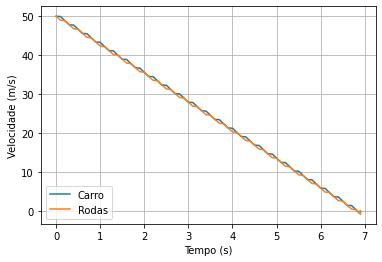

In [9]:
gera_traco(declare,init,trans,140,50)

# $b$

$I.$ ”o veículo imobiliza-se completamente em menos de $t$ segundos”

$$ 
P_1(m=STOPPED\,\land\,t<t_i)
$$

$II.$ “a velocidade $V$ diminui sempre com o tempo”

$$
P_2(t<t'\longrightarrow\,V>V')
$$

In [10]:
def prop1(s):
    return And(s['m']==STOPPED,s['t']<8)

def prop2(s,p):
    return Implies(s['t']<p['t'],s['V']>p['V'])

# $d$

Verificação das propriedades anteriores utilizando as funções das aulas $bmc_{eventually}$ e $bmc_{always}$

BMC_EVENTUALLY: dada uma função que gera uma cópia das variáveis do estado, 
um predicado que testa se um estado é inicial, 
um predicado que testa se um par de estados é uma transição válida, 
uma propriedade cuja inevitabilidade se pretende verificar, 
e um número positivo K, 
usea o Z3 para encontrar um contra-exemplo para essa propriedade considerando apenas os primeiros K estados de execução do programa. 


In [11]:
def bmc_eventually(declare,init,trans,prop,K,v):
    for k in range(1,K+1):
        s = Solver()
        traco = [declare(i) for i in range(k)]
        s.add(init(traco[0],v))
        for i in range(k-1):
            s.add(trans(traco[i],traco[i+1]))   
        for i in range(k):
          s.add(Not(prop(traco[i])))
        
    status=s.check()
    if status==sat:
            m=s.model()
            for i in range(k):
                print(i)
                for v in traco[i]:
                    print(v,"=",m[traco[i][v]])
            return
    print("A proposição pode ser verdadeira")

In [13]:
bmc_eventually(declare,init,trans,prop1,140,50)

A proposiçãp pode ser verdadeira


BMC_ALWAYS : dada uma função que gera uma cópia das variáveis do estado, um predicado que testa se um estado é inicial, um predicado que testa se um par de estados é uma transição válida, um invariante a verificar, e um número positivo K, usa o Z3 para verificar se esse invariante é sempre válido nos primeiros K-1 passos de execução do programa, ou devolve um contra-exemplo mínimo caso não seja.

In [14]:
def bmc_always(declare,init,trans,prop,K,v):
    for k in range(1,K+1):
        s = Solver()
        traco = [declare(i) for i in range(k)]
        s.add(init(traco[0],v))
        for i in range(k-1):
          s.add(trans(traco[i],traco[i+1]))
        if k!=1:
          s.add(Not(prop(traco[k-2],traco[k-1]))) 
        else:
          s.add(traco[k-1]['t']!=0)  

    if s.check()==sat :
          m = s.model()
          print('A propriedade falha')
          for i in range(k):
            print("Estado: ",i)
            for v in traco[i]:
              r = m[traco[i][v]]
              if r.sort() != RealSort():
                print(v,'=',r)
              else:
                print(v,'=',float(r.numerator_as_long())/float(r.denominator_as_long()))
          return 
    print("A propriedade é válida em traços de tamanho até "+str(K))

In [15]:
bmc_always(declare,init,trans,prop2,140,50)

A propriedade é válida em traços de tamanho até 200
